## Data Prep

**Import necessary modules and the ASOS/SNOTEL dataframes**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dtb
import os
from glob import glob
import datetime as dt
import seaborn as sns

In [2]:
data = [pd.read_csv('asos_snotel_UA_12hr_df.dat', parse_dates = True, index_col = 'Date_Time')]
asos_snotel_UA_df = pd.concat(data)
#asos_snotel_UA_df['LXV_WindSpeed_m/s']

#asos_snotel_UA_df.rename(columns={'LXV_WindSpeed_m/s': 'LXV_WindSpeed_mps'}, inplace=True)

asos_snotel_UA_df.astype('float16')
pd.set_option('display.expand_frame_repr', True)


print(asos_snotel_UA_df.keys())




#delete empty columns as they mess up loops
#del asos_snotel_UA_df['CMtn_6hr_Precipitation_mm']            #empty column


Index(['CMtnSNTL_Temp_degC', 'CMtnSNTL_SnowDepth_in', 'CMtn_Temperature_degC',
       'CMtn_Dewpoint_degC', 'CMtn_WindDirection_deg', 'CMtn_WindSpeed_mps',
       'CMtn_CloudCover_oktas', 'CMtn_1hr_Precipitation_mm',
       'LXV_Temperature_degC', 'LXV_Dewpoint_degC',
       ...
       'KGJT_d300_200_height_m', 'KGJT_d300_200_tmpc', 'KGJT_d300_200_dwpc',
       'KGJT_d300_200_drct', 'KGJT_d300_200_speed_kts',
       'KGJT_d250_200_height_m', 'KGJT_d250_200_tmpc', 'KGJT_d250_200_dwpc',
       'KGJT_d250_200_drct', 'KGJT_d250_200_speed_kts'],
      dtype='object', length=163)


In [3]:

all_yrs = (asos_snotel_UA_df.index >= '01-01-2006') & (asos_snotel_UA_df.index < '01-01-2018')
test_yrs_A=  ((asos_snotel_UA_df.index >= '01-01-2006') & (asos_snotel_UA_df.index < '01-01-2007')) | ((asos_snotel_UA_df.index >= '01-01-2017') & (asos_snotel_UA_df.index< '01-01-2018'))
train_yrs_A = (asos_snotel_UA_df.index >= '01-01-2007') & (asos_snotel_UA_df.index < '01-01-2017')

train_yrs_B = ((asos_snotel_UA_df.index >= '01-01-2006') & (asos_snotel_UA_df.index < '01-01-2014')) | ((asos_snotel_UA_df.index >= '01-01-2015') & (asos_snotel_UA_df.index < '01-01-2018'))
test_yrs_B = (asos_snotel_UA_df.index >= '01-01-2014') & (asos_snotel_UA_df.index < '01-01-2015')

It is important to keep in mind that 'CMtnSNTL_12hr_SNWD_in contains snow depth info taken at the start of the respective 12hr period timestamp.  The snowfall calculated also gives the snowfall that fell in the 12hrs after the timestamp.  The OLS model will utilize hourly meteorological measurements at exactly 00:00 and 12:00 hours to predict the amount of snow which will fall in the next 12 hour period.  For example, the 00:00 meteorological measurements will be used to predict the snow which fell between 00:00 and 12:00.

## Determine which columns to use in OLS model.   
### Only going to to keep those data columns which have a matching hour to at least 67% of the snowfall measurements

In [4]:
variables = ['CMtnSNTL_Temp_degC', 'CMtn_Temperature_degC', 'CMtn_Dewpoint_degC', 'CMtn_WindSpeed_mps', 'CMtn_CloudCover_oktas', \
 'LXV_Temperature_degC', 'LXV_Dewpoint_degC', 'LXV_Pressure_hp', 'LXV_WindSpeed_mps',  'LXV_CloudCover_oktas', 'LXV_12hr_delta_Pressure_hp', \
 'KGJT_200mb_height_m', 'KGJT_200mb_tmpc', 'KGJT_200mb_dwpc', 'KGJT_200mb_speed_kts', \
 'KGJT_250mb_height_m', 'KGJT_250mb_tmpc', 'KGJT_250mb_dwpc', 'KGJT_250mb_speed_kts', \
 'KGJT_300mb_height_m', 'KGJT_300mb_tmpc', 'KGJT_300mb_dwpc', 'KGJT_300mb_speed_kts', \
 'KGJT_400mb_height_m', 'KGJT_400mb_tmpc', 'KGJT_400mb_dwpc', 'KGJT_400mb_speed_kts', \
 'KGJT_500mb_height_m', 'KGJT_500mb_tmpc', 'KGJT_500mb_dwpc', 'KGJT_500mb_speed_kts', \
 'KGJT_700mb_height_m', 'KGJT_700mb_tmpc', 'KGJT_700mb_dwpc', 'KGJT_700mb_speed_kts', \
 'KGJT_850mb_height_m', 'KGJT_850mb_tmpc', 'KGJT_850mb_dwpc', 'KGJT_850mb_speed_kts', \
 'KGJT_d850_700_height_m', 'KGJT_d850_700_tmpc', 'KGJT_d850_700_dwpc', 'KGJT_d850_700_speed_kts', \
 'KGJT_d850_500_height_m', 'KGJT_d850_500_tmpc', 'KGJT_d850_500_dwpc', 'KGJT_d850_500_speed_kts', \
 'KGJT_d850_400_height_m', 'KGJT_d850_400_tmpc', 'KGJT_d850_400_dwpc', 'KGJT_d850_400_speed_kts', \
 'KGJT_d850_300_height_m', 'KGJT_d850_300_tmpc', 'KGJT_d850_300_dwpc', 'KGJT_d850_300_speed_kts', \
 'KGJT_d850_250_height_m', 'KGJT_d850_250_tmpc', 'KGJT_d850_250_dwpc', 'KGJT_d850_250_speed_kts', \
 'KGJT_d850_200_height_m', 'KGJT_d850_200_tmpc', 'KGJT_d850_200_dwpc', 'KGJT_d850_200_speed_kts',\
 'KGJT_d700_500_height_m', 'KGJT_d700_500_tmpc', 'KGJT_d700_500_dwpc', 'KGJT_d700_500_speed_kts', \
 'KGJT_d700_400_height_m', 'KGJT_d700_400_tmpc', 'KGJT_d700_400_dwpc', 'KGJT_d700_400_speed_kts', \
 'KGJT_d700_300_height_m', 'KGJT_d700_300_tmpc', 'KGJT_d700_300_dwpc', 'KGJT_d700_300_speed_kts', \
 'KGJT_d700_250_height_m', 'KGJT_d700_250_tmpc', 'KGJT_d700_250_dwpc', 'KGJT_d700_250_speed_kts', \
 'KGJT_d700_200_height_m', 'KGJT_d700_200_tmpc', 'KGJT_d700_200_dwpc', 'KGJT_d700_200_speed_kts', \
 'KGJT_d500_400_height_m', 'KGJT_d500_400_tmpc', 'KGJT_d500_400_dwpc', 'KGJT_d500_400_speed_kts', \
 'KGJT_d500_300_height_m', 'KGJT_d500_300_tmpc', 'KGJT_d500_300_dwpc', 'KGJT_d500_300_speed_kts', \
 'KGJT_d500_250_height_m', 'KGJT_d500_250_tmpc', 'KGJT_d500_250_dwpc', 'KGJT_d500_250_speed_kts', \
 'KGJT_d500_200_height_m', 'KGJT_d500_200_tmpc', 'KGJT_d500_200_dwpc', 'KGJT_d500_200_speed_kts', \
 'KGJT_d400_300_height_m', 'KGJT_d400_300_tmpc', 'KGJT_d400_300_dwpc', 'KGJT_d400_300_speed_kts', \
 'KGJT_d400_250_height_m', 'KGJT_d400_250_tmpc', 'KGJT_d400_250_dwpc', 'KGJT_d400_250_speed_kts', \
 'KGJT_d400_200_height_m', 'KGJT_d400_200_tmpc', 'KGJT_d400_200_dwpc', 'KGJT_d400_200_speed_kts', \
 'KGJT_d300_250_height_m', 'KGJT_d300_250_tmpc', 'KGJT_d300_250_dwpc', 'KGJT_d300_250_speed_kts', \
 'KGJT_d300_200_height_m', 'KGJT_d300_200_tmpc', 'KGJT_d300_200_dwpc', 'KGJT_d300_200_speed_kts', \
 'KGJT_d250_200_height_m', 'KGJT_d250_200_tmpc', 'KGJT_d250_200_dwpc', 'KGJT_d250_200_speed_kts']

good_vars = []
bad_vars = []
for var in variables:
    idx = np.isfinite(asos_snotel_UA_df[all_yrs]['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in']) & np.isfinite(asos_snotel_UA_df[all_yrs][var])
 #   total_poss = len(asos_snotel_UA_df[train_yrs]['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in'][asos_snotel_UA_df[train_yrs]['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in']>=0])
    
    total_poss = asos_snotel_UA_df[all_yrs]['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in'].count()   #counts only non missing values
    total_avail =len(asos_snotel_UA_df[all_yrs][idx]) 
    
    if total_avail/total_poss >= 0.67: 
        good_vars.append(var)
    else:
        bad_vars.append(var)
        
print('Variables with >= 67% data match to snowfall: ')
print(good_vars)
print('Variables with < 67% data match to snowfall: ')
print(bad_vars)
    




Variables with >= 67% data match to snowfall: 
['CMtnSNTL_Temp_degC', 'CMtn_Temperature_degC', 'CMtn_Dewpoint_degC', 'CMtn_WindSpeed_mps', 'LXV_Temperature_degC', 'LXV_Dewpoint_degC', 'LXV_Pressure_hp', 'LXV_WindSpeed_mps', 'LXV_12hr_delta_Pressure_hp', 'KGJT_200mb_height_m', 'KGJT_200mb_tmpc', 'KGJT_200mb_dwpc', 'KGJT_200mb_speed_kts', 'KGJT_250mb_height_m', 'KGJT_250mb_tmpc', 'KGJT_250mb_dwpc', 'KGJT_250mb_speed_kts', 'KGJT_300mb_height_m', 'KGJT_300mb_tmpc', 'KGJT_300mb_dwpc', 'KGJT_300mb_speed_kts', 'KGJT_400mb_height_m', 'KGJT_400mb_tmpc', 'KGJT_400mb_dwpc', 'KGJT_400mb_speed_kts', 'KGJT_500mb_height_m', 'KGJT_500mb_tmpc', 'KGJT_500mb_dwpc', 'KGJT_500mb_speed_kts', 'KGJT_700mb_height_m', 'KGJT_700mb_tmpc', 'KGJT_700mb_dwpc', 'KGJT_700mb_speed_kts', 'KGJT_850mb_height_m', 'KGJT_d850_700_height_m', 'KGJT_d850_500_height_m', 'KGJT_d850_400_height_m', 'KGJT_d850_300_height_m', 'KGJT_d850_250_height_m', 'KGJT_d850_200_height_m', 'KGJT_d700_500_height_m', 'KGJT_d700_500_tmpc', 'KGJT_d70

In [5]:
good_vars_snf =[]
filtered_asos_snotel_UA_df = pd.DataFrame()


good_vars_snf = good_vars + ['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in']
print(good_vars_snf )
filtered_asos_snotel_UA_df=  asos_snotel_UA_df[good_vars_snf].copy()
test_train_df = asos_snotel_UA_df[good_vars_snf].dropna()

print(asos_snotel_UA_df[good_vars_snf] ['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in']['2014'].describe())

['CMtnSNTL_Temp_degC', 'CMtn_Temperature_degC', 'CMtn_Dewpoint_degC', 'CMtn_WindSpeed_mps', 'LXV_Temperature_degC', 'LXV_Dewpoint_degC', 'LXV_Pressure_hp', 'LXV_WindSpeed_mps', 'LXV_12hr_delta_Pressure_hp', 'KGJT_200mb_height_m', 'KGJT_200mb_tmpc', 'KGJT_200mb_dwpc', 'KGJT_200mb_speed_kts', 'KGJT_250mb_height_m', 'KGJT_250mb_tmpc', 'KGJT_250mb_dwpc', 'KGJT_250mb_speed_kts', 'KGJT_300mb_height_m', 'KGJT_300mb_tmpc', 'KGJT_300mb_dwpc', 'KGJT_300mb_speed_kts', 'KGJT_400mb_height_m', 'KGJT_400mb_tmpc', 'KGJT_400mb_dwpc', 'KGJT_400mb_speed_kts', 'KGJT_500mb_height_m', 'KGJT_500mb_tmpc', 'KGJT_500mb_dwpc', 'KGJT_500mb_speed_kts', 'KGJT_700mb_height_m', 'KGJT_700mb_tmpc', 'KGJT_700mb_dwpc', 'KGJT_700mb_speed_kts', 'KGJT_850mb_height_m', 'KGJT_d850_700_height_m', 'KGJT_d850_500_height_m', 'KGJT_d850_400_height_m', 'KGJT_d850_300_height_m', 'KGJT_d850_250_height_m', 'KGJT_d850_200_height_m', 'KGJT_d700_500_height_m', 'KGJT_d700_500_tmpc', 'KGJT_d700_500_dwpc', 'KGJT_d700_500_speed_kts', 'KGJT_d

213
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
| Year           |   # of Events with Met |   Poss # of Events |   Mean |   Median |   Max |   Std Deviation |
|----------------|------------------------|--------------------|--------|----------|-------|-----------------|
| 2006           |                     21 |                 26 |    5   |      5   |  11   |            2.05 |
| 2007           |                     23 |                 29 |    3.9 |      3.3 |   6.5 |            1.18 |
| 2008           |                     25 |                 27 |    4.3 |      3.3 |   8   |            1.84 |
| 2009           |                     16 |                 27 |    3.9 |      3.8 |   6   |            0.87 |
| 2010           |                     20 |                 30 |    4.4 |      3.8 |   9   |            1.77 |
| 2011           |                      0 |                 32 |  nan   |    nan   | nan   |          nan    |
| 2012           |                      5 |  

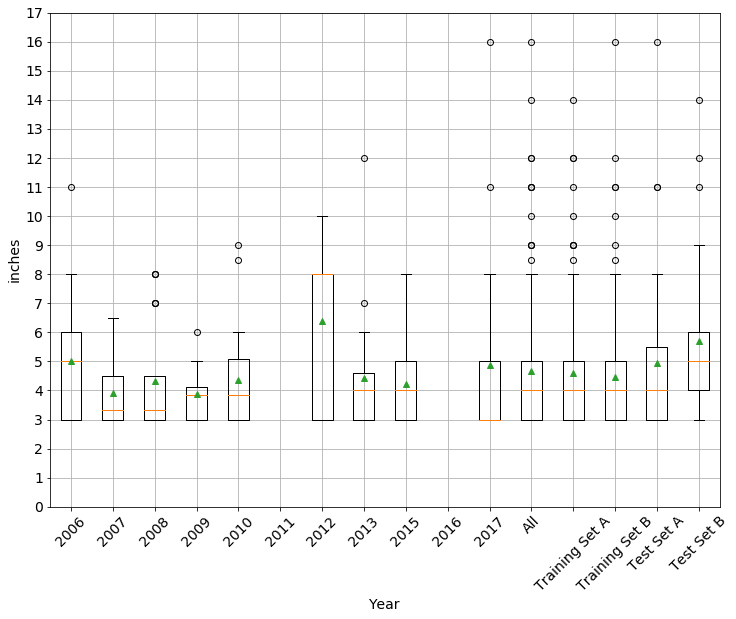

In [13]:
import statistics as sts
all_yrs_tt = (test_train_df.index >= '01-01-2006') & (test_train_df.index < '01-01-2018')
test_yrs_tt_A=  ((test_train_df.index >= '01-01-2006') & (test_train_df.index < '01-01-2007')) | ((test_train_df.index >= '01-01-2017') & (test_train_df.index< '01-01-2018'))
train_yrs_tt_A = (test_train_df.index >= '01-01-2007') & (test_train_df.index < '01-01-2017')

train_yrs_tt_B = ((test_train_df.index >= '01-01-2006') & (test_train_df.index < '01-01-2014')) | ((test_train_df.index >= '01-01-2015') & (test_train_df.index < '01-01-2018'))
test_yrs_tt_B = (test_train_df.index >= '01-01-2014') & (test_train_df.index < '01-01-2015')

print(len(train_yrs_tt_A))
from tabulate import tabulate
years = ['2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2015', '2016', '2017', all_yrs_tt, train_yrs_tt_A, train_yrs_tt_B, test_yrs_tt_A, test_yrs_tt_B]
year_lbls = ['2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2015', '2016', '2017', 'All', 'Training Set A', 'Training Set B', 'Test Set A', 'Test Set B',]
years2 = ['2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2015', '2016', '2017', all_yrs, train_yrs_A, train_yrs_B, test_yrs_A, test_yrs_B]
counts = []
means = []
maxes = []
sd_missings =[]
std_devs=[]
medians = []
possible_snf = []
data2plot = []

for year in years:


    counts.append(test_train_df['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in'][year].count())
    maxes.append((round(test_train_df['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in'][year].max(),1)))
    means.append(round(test_train_df['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in'][year].mean(),1))
    medians.append(round(test_train_df['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in'][year].median(),1))
    
    #sd_missings.append(round(filtered_asos_snotel_UA_df['CMtnSNTL_12hr_SNWD_in'][year].count()/len(filtered_asos_snotel_UA_df['CMtnSNTL_12hr_SNWD_in'][year][idx])/12*100,2))
    std_devs.append(round(np.std(test_train_df['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in'][year].dropna()),2))
    #print(filtered_asos_snotel_UA_df['CMtnSNTL_12hr_SNWD_in'][year].count(),len(filtered_asos_snotel_UA_df['CMtnSNTL_12hr_SNWD_in'][year])/12)
    data2plot.append(test_train_df['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in'][year].values.tolist())
   
    
    
#Calculate potential snowfalls
for year in years2:
    possible_snf.append(asos_snotel_UA_df['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in'][year].count())
    
    
tbl = zip(year_lbls, counts, possible_snf, means, medians, maxes,std_devs )  
fig = plt.figure(figsize=(12,20))

ax = fig.add_subplot(211)

plt.boxplot(data2plot, showmeans=True)  
#plt.title('Box Plot of ' + keys[k])
ax.set_xticklabels(year_lbls, rotation = 45, fontsize = 14)

v = list(np.arange(0,18,1))
print(v)
ax.set_yticks(v)
ax.set_yticklabels(v, fontsize = 14)
ax.set_xlabel('Year', fontsize = 14)
ax.set_ylabel('inches', fontsize = 14)
#ax.set_ylabel(keys[k])


print(tabulate(tbl, headers=['Year', '# of Events with Met', "Poss # of Events", 'Mean', 'Median','Max',  'Std Deviation'], tablefmt='github'))
print(medians)
plt.grid(True)

plt.savefig('C:/Users/RAPP/Documents/Capstone/Report/figs/model_snowfall.png', bbox_inches='tight')


print(v)

count    213.000000
mean       4.668404
std        2.164714
min        3.000000
25%        3.000000
50%        4.000000
75%        5.000000
max       16.000000
Name: CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in, dtype: float64


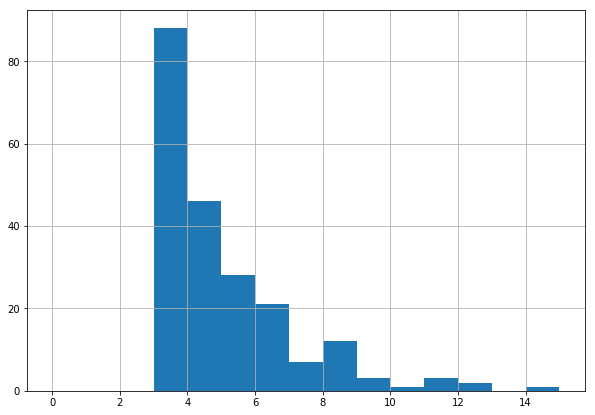

count    213.000000
mean       4.668404
std        2.164714
min        3.000000
25%        3.000000
50%        4.000000
75%        5.000000
max       16.000000
Name: CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in, dtype: float64


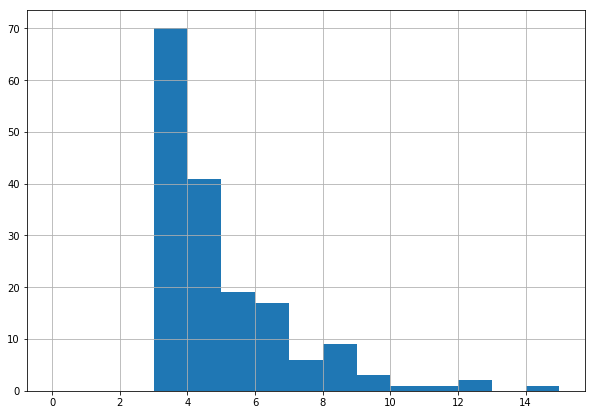

count    213.000000
mean       4.668404
std        2.164714
min        3.000000
25%        3.000000
50%        4.000000
75%        5.000000
max       16.000000
Name: CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in, dtype: float64


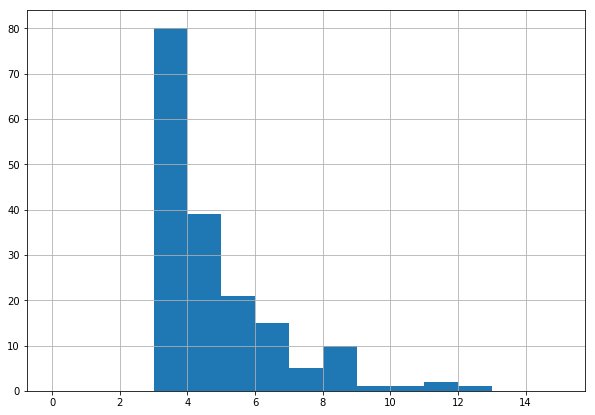

count    213.000000
mean       4.668404
std        2.164714
min        3.000000
25%        3.000000
50%        4.000000
75%        5.000000
max       16.000000
Name: CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in, dtype: float64


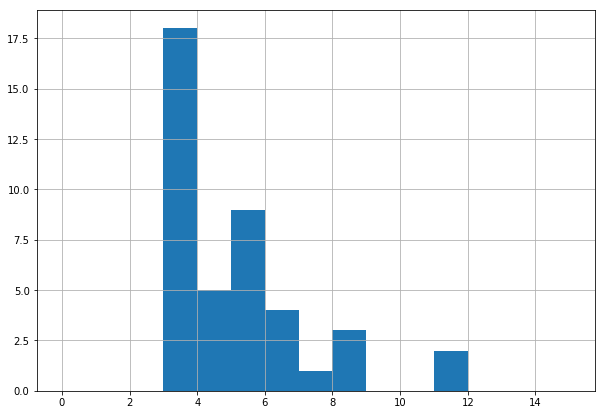

count    213.000000
mean       4.668404
std        2.164714
min        3.000000
25%        3.000000
50%        4.000000
75%        5.000000
max       16.000000
Name: CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in, dtype: float64


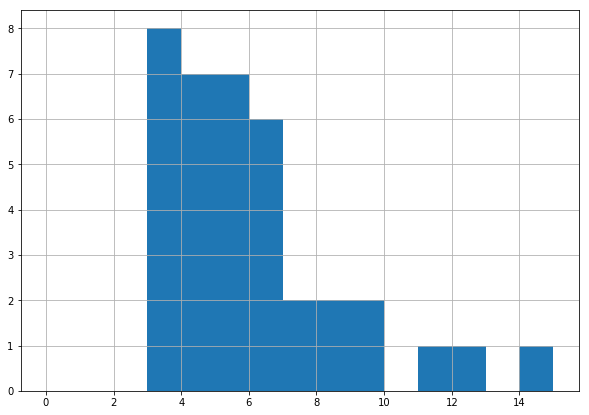

In [7]:
years = [all_yrs_tt, train_yrs_tt_A, train_yrs_tt_B, test_yrs_tt_A, test_yrs_tt_B]
year_lbls = ['All', 'Training Set A', 'Training Set B', 'Test Set A', 'Test Set B',]
for year in years:
  hist = test_train_df['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in'][year].hist(figsize=(10,7), bins = np.arange(0,16,1))
  print(test_train_df['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in'].describe())
  plt.show()

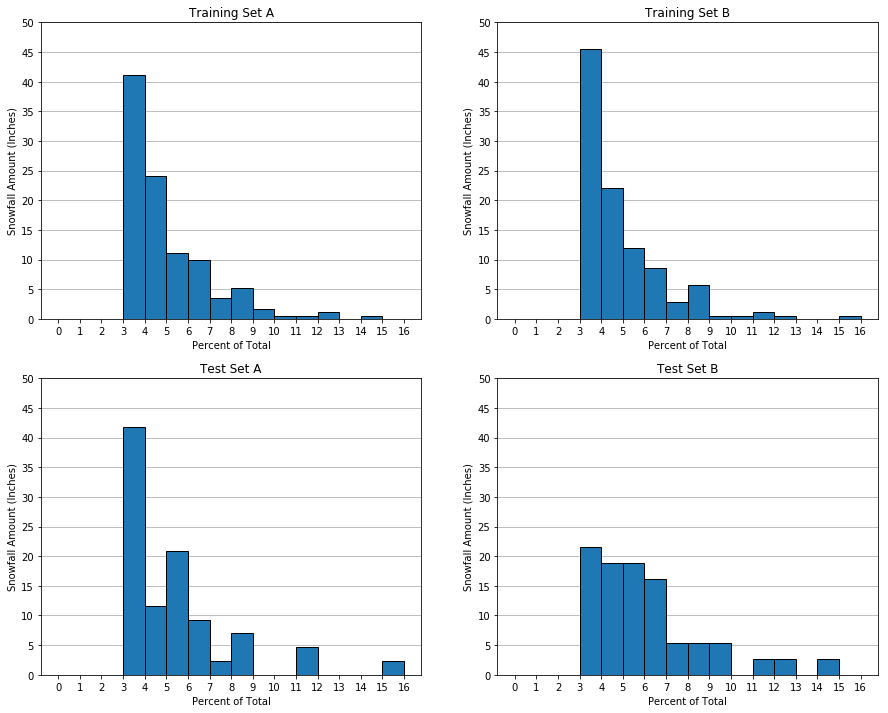

<Figure size 432x288 with 0 Axes>

In [21]:
years = [all_yrs_tt, train_yrs_tt_A, train_yrs_tt_B, test_yrs_tt_A, test_yrs_tt_B]
year_lbls = ['All', 'Training Set A', 'Training Set B', 'Test Set A', 'Test Set B',]
fig = plt.figure(figsize=(15,12))
for k in np.arange(1, len(years),1):
  ax = plt.subplot(2,2, k)
  weights = np.ones_like(test_train_df['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in'][years[k]])/float(len(test_train_df['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in'][years[k]]))
  plt.hist(test_train_df['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in'][years[k]], histtype = 'bar', weights=weights*100, \
           bins = np.arange(0,17,1), align = 'mid', edgecolor = 'black') 
  plt.xticks(np.arange(0,17,1))
  plt.xlabel('Percent of Total')
  plt.ylabel('Snowfall Amount (Inches)' )
  plt.ylim(0,50)
  plt.yticks(np.arange(0,55,5))
  ax.set_axisbelow(True)
  plt.grid(True, axis = 'y')
  plt.title(year_lbls[k])
plt.show()
plt.savefig('C:/Users/RAPP/Documents/Capstone/Report/figs/snowfall_histogram.png', bbox_inches='tight')
#ax.set_yticklabels(np.arange(0,50,10), fontsize = 14)